In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [122]:
image = cv2.imread('test1.jpg')

In [123]:
def show_image(img, color=0):
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

In [124]:
def crop_image(image, x_min, x_max, y_min, y_max):
    # Cắt phần ảnh từ (x_min, y_min) đến (x_max, y_max)
    cropped_image = image[y_min:y_max, x_min:x_max]
    return cropped_image

In [125]:
def check_tick(image):
    # Đếm số lượng pixel màu đen (pixel có giá trị 0)
    total_pixels = image.size
    black_pixels = cv2.countNonZero(image)

    # Tính phần trăm pixel màu đen
    black_percentage = (1 - black_pixels / total_pixels) * 100

    # Kiểm tra nếu phần trăm pixel màu đen >= 20%
    return black_percentage >= 10

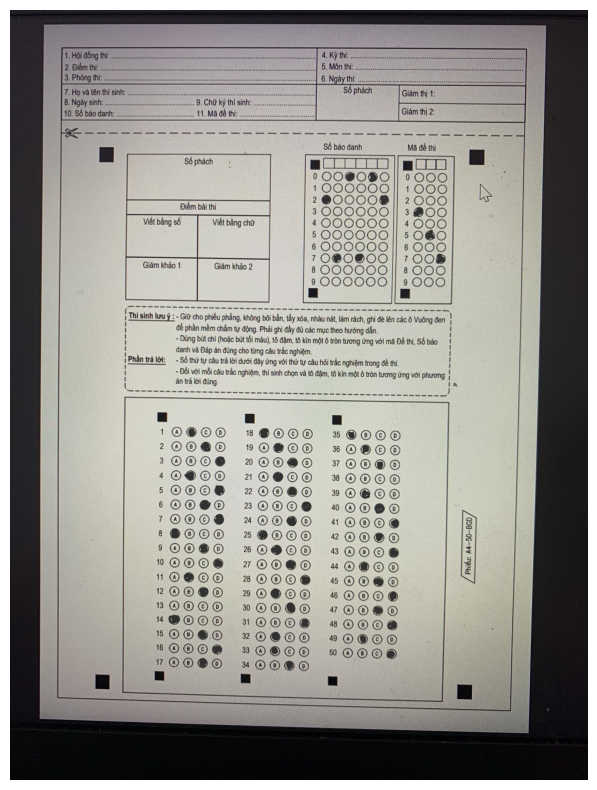

In [126]:
show_image(image)

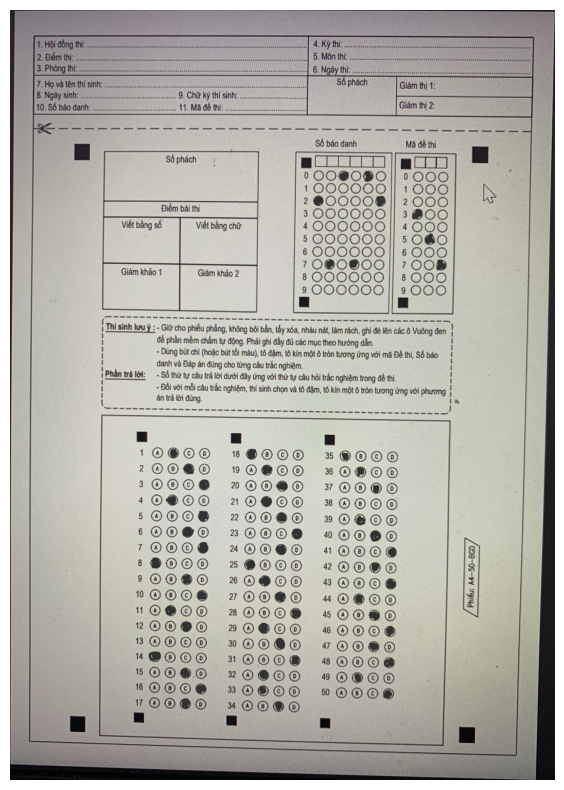

In [127]:
def resize_paper(image, target_width, target_height):
    # Chuyển đổi ảnh sang ảnh grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Áp dụng Gaussian blur để làm mờ ảnh
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Phát hiện đường viền trong ảnh
    edges = cv2.Canny(blurred, 50, 150)

    # Tìm các contours trong đường viền
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sắp xếp các contours theo diện tích giảm dần
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Xác định vùng quan tâm chứa tờ giấy (giả sử lấy contour lớn nhất)
    if len(contours) > 0:
        largest_contour = contours[0]
        x, y, w, h = cv2.boundingRect(largest_contour)
        roi = (x, y, w, h)
    else:
        # Không tìm thấy contour
        return None

    # Cắt vùng quan tâm ra từ ảnh gốc
    paper = image[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]

    # Thay đổi kích thước tờ giấy
    resized_paper = cv2.resize(paper, (target_width, target_height))

    return resized_paper


# Thực hiện thay đổi kích thước tờ giấy về 1653x2339
image = resize_paper(image, 1653, 2339)
show_image(image)

In [128]:
image.shape[:2]

(2339, 1653)

In [129]:
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
_, threshold = cv2.threshold(imgray, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contours, hierarchy = cv2.findContours(threshold, cv2.RETR_TREE , cv2.CHAIN_APPROX_SIMPLE)

In [130]:
img_copy = image.copy()
cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 2);

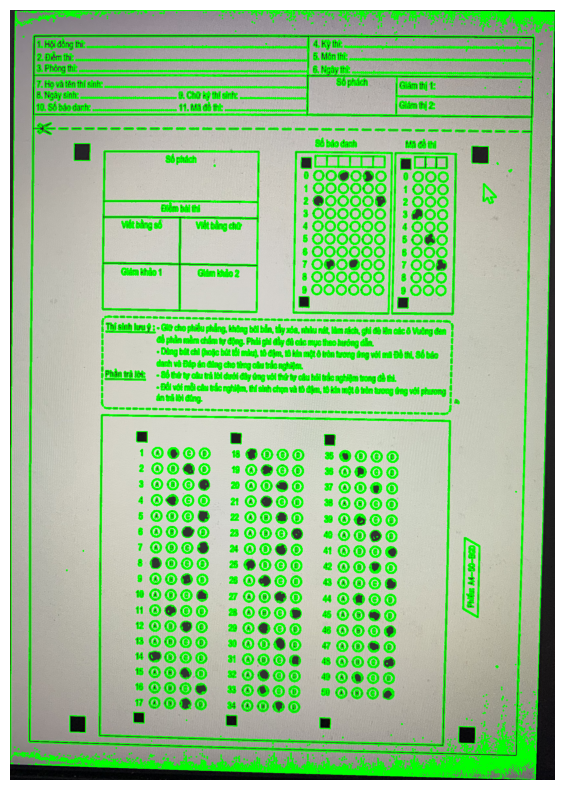

In [131]:
show_image(img_copy)

In [132]:
len(contours)

6612

In [133]:
def is_square(contour):
     # Tính bounding box của contour
    x, y, w, h = cv2.boundingRect(contour)

    # Tính tỷ lệ chiều dài và chiều rộng của bounding box
    aspect_ratio = float(w) / h

    # Tính diện tích của contour
    area = cv2.contourArea(contour)

    # Tính tỷ lệ diện tích của contour và diện tích của bounding box
    extent = float(area) / (w * h)
    return (0.8 <= aspect_ratio <= 1.2) and (0.8 <= extent <= 1.2)

In [134]:
def get_square(image, contours):
    img_copy = image.copy()
    square_contours = []
    for contour in contours:
        if is_square(contour) and (600 < cv2.contourArea(contour) < 3500):
            square_contours.append(contour)
            cv2.drawContours(img_copy, [contour], 0, (0, 255, 0), 2)
    print('Số hình vuông tìm thấy: ', len(square_contours))
    return img_copy, square_contours

Số hình vuông tìm thấy:  23


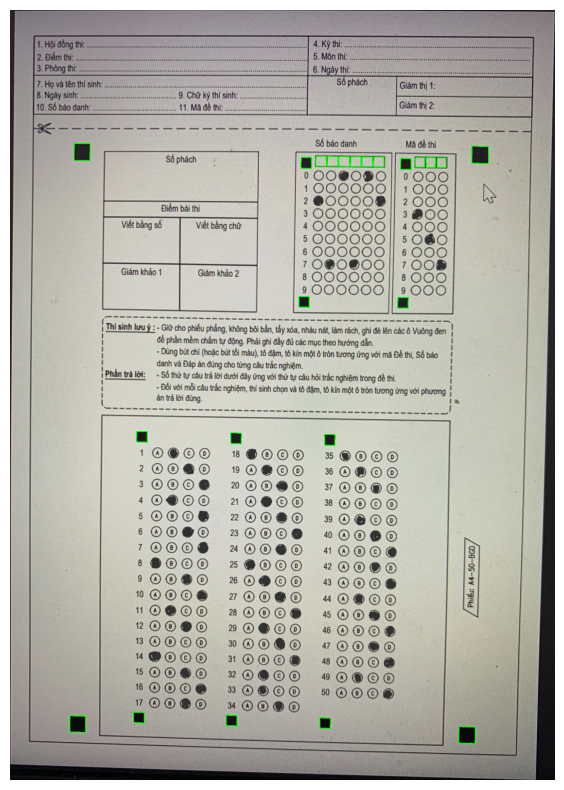

In [135]:
img_copy, square_contours = get_square(image, contours)
show_image(img_copy)

In [136]:
def get_location(image, square_contours):
    img_copy = image.copy()
    # sắp xếp square_contours theo thứ tự area tăng dần
    sorted_contours = sorted(square_contours, key=cv2.contourArea)
    sorted_contours = sorted_contours[:-(len(sorted_contours) - 19)]
    
    def sort_by_y_then_x(square):
        x, y, w, h = cv2.boundingRect(square)
        return (y, x)

    # Sắp xếp theo y tăng dần và x nếu y gần nhau
    sorted_square = sorted(sorted_contours, key=sort_by_y_then_x)
    sorted_square = sorted_square[9:]
    # In danh sách đã sắp xếp
    cv2.drawContours(img_copy, sorted_square, -1, (0, 255, 0), 2)
    show_image(img_copy)
    for square in sorted_square:
        x, y, w, h = cv2.boundingRect(square)
        print(f"Square: x={x}, y={y}, w={w}, h={h}")
    return sorted_square

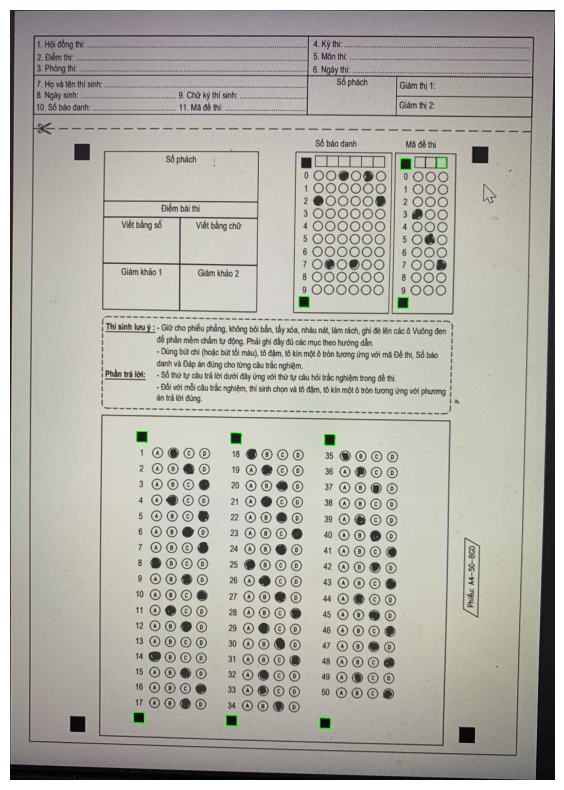

Square: x=1295, y=449, w=28, h=31
Square: x=1184, y=450, w=34, h=36
Square: x=876, y=870, w=33, h=35
Square: x=1175, y=872, w=34, h=35
Square: x=383, y=1280, w=34, h=34
Square: x=669, y=1284, w=34, h=35
Square: x=953, y=1289, w=34, h=35
Square: x=374, y=2132, w=34, h=35
Square: x=655, y=2141, w=34, h=35
Square: x=939, y=2149, w=34, h=35


In [137]:
sorted_square = get_location(image, square_contours)

In [138]:
def get_SBD(sorted_square):
    x_min = cv2.boundingRect(sorted_square[2])[0] + cv2.boundingRect(sorted_square[2])[2] 
    x_max = cv2.boundingRect(sorted_square[3])[0] - cv2.boundingRect(sorted_square[2])[2]
    y_min = cv2.boundingRect(sorted_square[1])[1] + cv2.boundingRect(sorted_square[1])[3]
    y_max = cv2.boundingRect(sorted_square[2])[1] 
    
    img_crop = crop_image(image, x_min, x_max, y_min, y_max)
    imgray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(imgray, 25)
    thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    height, width = thresh.shape
    show_image(img_crop)
    # Tính kích thước phần chia
    division_size_vertical = height // 10
    division_size_horizontal = width // 6
    # Khởi tạo kết quả
    SBD = ''

    # Lặp qua các phần chia
    for i in range(6):
        tiked = False
        for j in range(10):
            # Tọa độ của phần chia hiện tại
            y_min = j * division_size_vertical
            y_max = (j + 1) * division_size_vertical
            x_min = i * division_size_horizontal
            x_max = (i + 1) * division_size_horizontal

            # Lưu tọa độ vào kết quả
            if check_tick(thresh[y_min:y_max, x_min:x_max]):
                SBD += str(j)
                tiked = True
                break
        if tiked == False:
            return "Chưa tô đủ số báo danh"
        
    return SBD

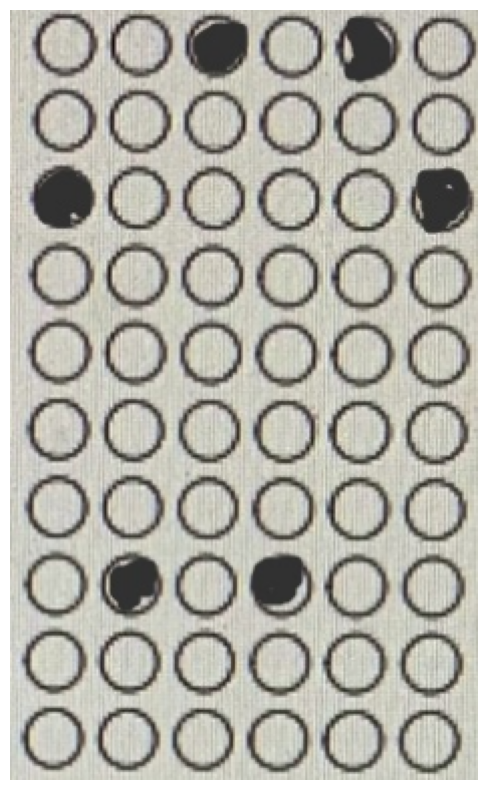

'270702'

In [139]:
sbd = get_SBD(sorted_square)
sbd

In [140]:
def get_ma_de(sorted_square):
    x_min = cv2.boundingRect(sorted_square[3])[0] + cv2.boundingRect(sorted_square[3])[2]
    x_max = cv2.boundingRect(sorted_square[3])[0] + int((cv2.boundingRect(sorted_square[3])[0] - cv2.boundingRect(sorted_square[2])[0])/2)
    y_min = cv2.boundingRect(sorted_square[1])[1] + cv2.boundingRect(sorted_square[1])[3]
    y_max = cv2.boundingRect(sorted_square[2])[1] 
    
    img_crop = crop_image(image, x_min, x_max, y_min, y_max)
    imgray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(imgray, 25)
    thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    height, width = thresh.shape
    show_image(img_crop)
    # Tính kích thước phần chia
    division_size_vertical = height // 10
    division_size_horizontal = width // 3
    # Khởi tạo kết quả
    ma_de = ''

    # Lặp qua các phần chia
    for i in range(3):
        tiked = False
        for j in range(10):
            # Tọa độ của phần chia hiện tại
            y_min = j * division_size_vertical
            y_max = (j + 1) * division_size_vertical
            x_min = i * division_size_horizontal
            x_max = (i + 1) * division_size_horizontal

            # Lưu tọa độ vào kết quả
            if check_tick(thresh[y_min:y_max, x_min:x_max]):
                ma_de += str(j)
                tiked = True
                break
        if tiked == False:
            return "Chưa tô đủ mã đề"
        
    return ma_de

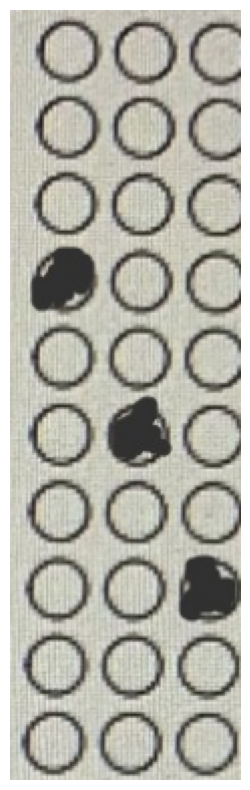

'357'

In [141]:
ma_de = get_ma_de(sorted_square)
ma_de

In [142]:
def get_answer_location(sorted_square):
    
    y_min= cv2.boundingRect(sorted_square[4][1])[1] + int(cv2.boundingRect(sorted_square[4])[3] * 3/2)
    y_max = cv2.boundingRect(sorted_square[7][1])[1] - int(cv2.boundingRect(sorted_square[4])[3] * 1/2)
    # Column 1
    x_min_cl1 = cv2.boundingRect(sorted_square[4][0])[0] + cv2.boundingRect(sorted_square[4])[2]
    x_max_cl1 = cv2.boundingRect(sorted_square[5][0])[0] - int(cv2.boundingRect(sorted_square[4])[2] * 2)
    
    
    # Column 2
    x_min_cl2 = cv2.boundingRect(sorted_square[5][0])[0] + cv2.boundingRect(sorted_square[4])[2]
    x_max_cl2 = cv2.boundingRect(sorted_square[6][0])[0] - int(cv2.boundingRect(sorted_square[4])[2] * 2)
   
    # Column 3
    x_min_cl3 = cv2.boundingRect(sorted_square[6][0])[0] + cv2.boundingRect(sorted_square[4])[2]
    x_max_cl3 = x_min_cl3 + x_max_cl2 - x_min_cl2
    colum1 = [x_min_cl1, x_max_cl1, y_min, y_max]
    colum2 = [x_min_cl2, x_max_cl2, y_min, y_max]
    colum3 = [x_min_cl3, x_max_cl3, y_min, y_max]
    return colum1, colum2, colum3
    

In [143]:
cl1, cl2, cl3 = get_answer_location(sorted_square)

In [144]:
cl1

[418, 601, 1331, 2115]

In [145]:
cl2

[703, 885, 1331, 2115]

In [146]:
cl3

[987, 1169, 1331, 2115]

In [147]:
def get_ans_column(image,column):
    x_min_cl, x_max_cl, y_min, y_max = column
    num_row = 17
    num_colums = 4
    
    img_crop = crop_image(image, x_min_cl, x_max_cl, y_min, y_max)
    
    imgray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(imgray, 25)
    thresh = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    show_image(thresh)
    # Kích thước ảnh
    height, width = thresh.shape

    # Tính kích thước phần chia
    division_size_vertical = height // num_row
    division_size_horizontal = width // num_colums

    # Khởi tạo kết quả
    results = []

    # Lặp qua các phần chia
    for i in range(num_row):
        for j in range(num_colums):
            # Tọa độ của phần chia hiện tại
            y_min = i * division_size_vertical
            y_max = (i + 1) * division_size_vertical
            x_min = j * division_size_horizontal
            x_max = (j + 1) * division_size_horizontal

            # Lưu tọa độ vào kết quả
            results.append(thresh[y_min:y_max, x_min:x_max])
    return results

In [148]:
def get_answer(cl1, cl2, cl3):
    full_ans = []
    full_ans.extend(cl1)
    full_ans.extend(cl2)
    full_ans.extend(cl3)
    ans_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
    ans = []
    for i in range(50):
        ticked = False
        for j in range(4):
            index = i * 4 + j
            if check_tick(full_ans[index]):
                ans.append(list(ans_dict.keys())[list(ans_dict.values()).index(j)])
                ticked = True
                break
        if not ticked:
            ans.append('NaN')
    return ans 

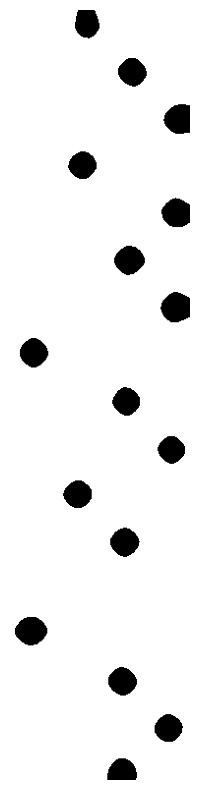

In [149]:
ans_cl1 = get_ans_column(image,cl1)

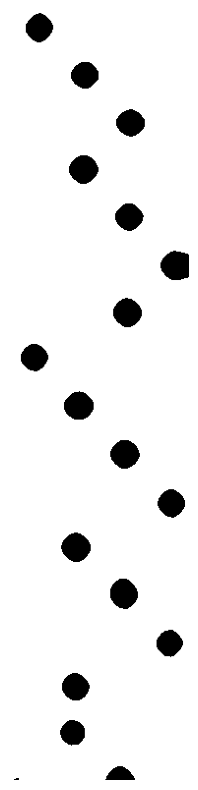

In [150]:
ans_cl2 = get_ans_column(image,cl2)

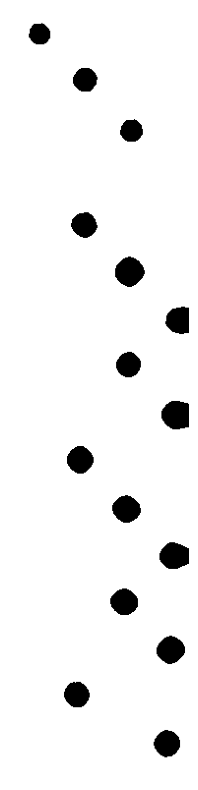

In [151]:
ans_cl3 = get_ans_column(image,cl3)

In [152]:
import pandas as pd
result = pd.read_excel('result.xlsx')
result = np.array(result['Đáp án'])
result

array(['C', 'C', 'A', 'C', 'D', 'C', 'C', 'A', 'C', 'D', 'C', 'C', 'A',
       'C', 'D', 'C', 'C', 'A', 'C', 'D', 'C', 'C', 'A', 'C', 'D', 'C',
       'C', 'A', 'C', 'D', 'C', 'C', 'A', 'C', 'D', 'C', 'C', 'A', 'C',
       'D', 'C', 'C', 'A', 'C', 'D', 'C', 'C', 'A', 'C', 'D'],
      dtype=object)

In [153]:
# Đọc danh sách đáp án từ file Excel
result = pd.read_excel('result.xlsx')
result = np.array(result['Đáp án'])

# So sánh ans và result
score = np.sum(ans == result) / len(result) * 10

# In kết quả điểm số
print("Số báo danh:", sbd)
print("Mã đề:", ma_de)
print("Điểm số:", score)

Số báo danh: 270702
Mã đề: 357
Điểm số: 2.4
